# HMC on Alcohol Consumption of Students 

regression on the final math grade of sutdents [1] 

 - dataset covering alcohol consumption among students 
 - features: education, family size and education, study times, leisure times etc. 
 - 30 features in total; target is overall math grade $\in \{0,20\}$

## Model Definition
 - regression with $y \sim \mathcal{N}(X\beta, \sigma^2_y I)$
 - $\beta \sim \mathcal{N}(0, \sigma^2_{\beta} I), \quad \sigma_{\beta} = 10$
 - $\sigma_y \sim \mathcal{IG}(\alpha=1, \beta=1)$
 - parameter vector $\theta = (\beta_0, \dots, \beta_n, \sigma_y)'$
 - derive prop. log posterior and its gradient
     $$
     \begin{align}
         \log p(\beta, \sigma^2 \vert \cdot) &\propto \log p(y \vert \cdot) + \log p(\beta \vert \cdot) + \log p(\sigma^2 \vert \cdot)  \\
         \nabla_{\beta, \sigma^2} \log p(\beta, \sigma^2 \vert \cdot) &\propto \left(\nabla_{\beta} \log p(\beta, \sigma^2 \vert \cdot), \nabla_{\sigma^2} \log p(\beta, \sigma^2 \vert \cdot)\right) 
     \end{align}
     $$

In [82]:
import datetime
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import pickle
import time
import warnings
import sys
sys.path.append("..")
warnings.filterwarnings('ignore')

# hmc implementation 
from hmc_sampling import run_hmc_sampler
# log posterior and grad. of log posterior 
from students_functions import log_posterior, log_posterior_grad
from utils_sampling import gelman_rubin, quantiles_per_chain
from utilities_plotting import plot_histograms, plot_traces
from scipy.stats import norm as normal_dist

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# account for jupyter theme
from jupyterthemes import jtplot
jtplot.style(theme='grade3')  # some bright theme 

In [17]:
data = pd.read_csv("../data/students_alcohol/student-mat.csv", 
                   sep=",", header=0)
print(data.shape)
# data.head()

(395, 33)


In [19]:
# numeric encoding of variables 
one_hot_school = pd.get_dummies(data["school"], prefix="school")
one_hot_sex = pd.get_dummies(data["sex"], prefix="sex")
one_hot_address = pd.get_dummies(data["address"], prefix="address")
one_hot_pstatus = pd.get_dummies(data["Pstatus"], prefix="pstatus")
one_hot_fams = pd.get_dummies(data["famsize"], prefix="famsize")
one_hot_mjob = pd.get_dummies(data['Mjob'], prefix='mother_job')
one_hot_fjob = pd.get_dummies(data['Fjob'], prefix='father_job')
one_hot_reason = pd.get_dummies(data["reason"], prefix="reason")
one_hot_guardian = pd.get_dummies(data["guardian"], prefix="guardian")
one_hot_schoolsup = pd.get_dummies(data["schoolsup"], prefix="schoolsup")
one_hot_famsup = pd.get_dummies(data["famsup"], prefix="famsup")
one_hot_paid = pd.get_dummies(data["paid"], prefix="paid")
one_hot_activities = pd.get_dummies(data["activities"], prefix="activities")
one_hot_nursery = pd.get_dummies(data["nursery"], prefix="nursery")
one_hot_higher = pd.get_dummies(data["higher"], prefix="higher")
one_hot_internet = pd.get_dummies(data["internet"], prefix="internet")
one_hot_romantic = pd.get_dummies(data["romantic"], prefix="romantic")

In [35]:
# add encoded columns 
data_numeric = pd.concat([data, one_hot_fjob, one_hot_mjob, one_hot_reason, one_hot_guardian, 
                          one_hot_school["school_GP"], one_hot_sex["sex_M"], one_hot_address["address_U"], 
                          one_hot_pstatus["pstatus_A"], one_hot_fams["famsize_GT3"], 
                          one_hot_schoolsup["schoolsup_yes"], one_hot_famsup["famsup_yes"],
                          one_hot_paid["paid_yes"], one_hot_activities["activities_yes"], 
                          one_hot_nursery["nursery_yes"], one_hot_higher["higher_yes"], 
                          one_hot_internet["internet_yes"], one_hot_romantic["romantic_yes"]], 
                         axis=1)
# remove non-numeric columns 
data_numeric.drop(["school", "sex", "address", "famsize", "Pstatus", "Fjob", "Mjob", "reason", "guardian", 
                   "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", 
                   "romantic"], axis=1, inplace=True)
print(data_numeric.shape)  # now 43 featrues instead of 30!
# data_numeric.head()

(395, 46)


In [33]:
# instpect the grades distribution
fig = plt.figure(figsize=(12,12))

mu = np.mean(y)
sigma = np.std(y)
bins = np.arange(-5, 25, 0.001)

ax = fig.add_subplot(111)
ax.hist(data["G3"].values, bins=20, color="green", density=True)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (
    2 * sigma**2) ), linewidth=4, color='orange', 
    label=f"true dist., $\mu$={mu:.2f}, $\sigma^2$={sigma:.2f}")

ax.set_title("Distribution of final math grades", fontsize=24)
ax.set_xlabel("grade", fontsize=18)
ax.set_ylabel("count", fontsize=18)
ax.legend()

plt.savefig("../../seminar_paper/figures/students_grade_distr.png", transparent=True)
plt.show();

In [36]:
# split in features and labels 
y = data_numeric["G3"].to_numpy()
y_std = (y - np.mean(y)) / np.std(y)

y_std_passed = y_std[y > 0]
print(f"passed tests: \t\t{y_std_passed.shape}")

# drop the label columns 
data_numeric.drop(["G1", "G2", "G3"], inplace=True, axis=1)

# rest of data are features and add intercept
X = data_numeric.to_numpy()
X[:, 0] = (X[:, 0] - X[:, 0].mean() / X[:, 0].std())
X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
X_passed = X[y>0, :]
# print(f"inspect head of data:\n {X[:10, :]}")

print(f"size features:\t\t {X.shape}")
print(f"size features (passed):\t {X_passed.shape}")
print(f"size labels:\t\t {y.shape}")
print(f"size labels (passed):\t {y_std_passed.shape}")

passed tests: 		(357,)
size features:		 (395, 44)
size features (passed):	 (357, 44)
size labels:		 (395,)
size labels (passed):	 (357,)


### HMC Setup 

In [37]:
num_features = X.shape[1]

# generate random init. params based on prioris 
coeffs1 = np.ones(num_features + 1)
coeffs2 = np.random.rand(num_features + 1)
coeffs3 = np.random.randn(num_features + 1)
coeffs4 = np.random.randn(num_features + 1) * 10
coeffs = np.array([coeffs1, coeffs3])

# print(f"init coeff: \n{coeffs}")
print(coeffs.shape)
# covariance matrix for kinetic energy
mass_matrix = np.eye(num_features + 1) * 10

(2, 45)


In [38]:
# set hyperparameters 
sampling_steps = int(1E4)
stepsize = 0.001
leapfrog_steps = 10
burnin = 2500

In [141]:
# track runtime 
start = time.time()

# run HMC sampling 
samples_passed, acceptance_probs_passed = run_hmc_sampler(init_params=coeffs, 
                                            total_iterations=sampling_steps, burnin=burnin, 
                                            mass_matrix=mass_matrix, epsilon=stepsize, 
                                            leapfrog_steps=leapfrog_steps, data=X_passed, labels=y_std_passed)
end = time.time()

pickle.dump(experiment, open(
    f"experiment_{coeffs.shape[0]}chains_{sampling_steps / 1000}K_{timestamp}.p", "wb"))

print(f"runtime: {end - start:.2f} sec.")
for t in range(samples.shape[0]):
    print(f"acceptance prob. of chain {t+1}: {acceptance_probs[t].mean():.3f}")

100%|██████████| 2/2 [26:35<00:00, 797.98s/it]runtime: 1595.95 sec.
acceptance prob. of chain 1: 0.756
acceptance prob. of chain 2: 0.759



In [143]:
# save samples 
experiment = {"chains": coeffs.shape[0], "num_samples": sampling_steps, "samples": samples_passed, 
              "acceptance_ratio": acceptance_probs_passed}
timestamp = datetime.datetime.now().strftime("%H-%M") 

pickle.dump(experiment, open(f"experiment_{coeffs.shape[0]}chains_{sampling_steps / 1000}K_{timestamp}_passed.p", "wb"))

In [39]:
# load saved experiment 
file_name = "./experiment_2chains_10.0K_15-34_passed.p"
file = open(file_name, "rb")

data_loaded = pickle.load(file)
file.close()

In [40]:
# extract samples 
samples_passed = data_loaded["samples"]
samples_passed.shape

(2, 10000, 45)

### Trace plots

 - ...

In [41]:
# plot the traces of samples per chain to observe convergence 
# p = plot_traces(samples_passed[:, burnin:, :])
# plt.show(p);

### Posterior Distributions

 - ...

In [42]:
# plot the distribution of samples per chain and credible intervals 
# .5 and .94 quantiles for the 89% credible intervals [2] in blue 
# p = plot_histograms(samples[:, burnin:, :])
# plt.show(p);

In [43]:
print(f"Gelman Rubin metric: {gelman_rubin(samples_passed)}")

Gelman Rubin metric: [ 3.34959243  1.13549061  1.47075319  1.3697066   1.59574764  1.21197632
  3.47932879  1.41895241  1.09465618  1.73464984  1.00717795  2.16242951
  1.11255816  0.99995522  4.57722302 20.39766983  1.93802818  7.91801563
  1.88251128 12.53242742  8.11736979  6.26277735  1.26847438 13.36191981
  1.21219397  5.29188567  6.65197803  8.24488318  6.36865994  3.18689711
  4.96783169  6.14004723  4.66966882  3.36031395  9.68044039  3.38278982
  6.48413685  1.04260971  5.54742513  1.0015543   4.40744317  4.73828869
  4.37986228  6.22072907  1.22775604]


In [64]:
print(f"number converged covar.: {np.sum(gelman_rubin(samples_passed) <= 1.3)}")
cov = np.arange(1, gelman_rubin(samples_passed).__len__() + 1, 1)
print(cov * (gelman_rubin(samples_passed) <= 1.3))

number converged covar.: 11
[ 0  2  0  0  0  6  0  0  9  0 11  0 13 14  0  0  0  0  0  0  0  0 23  0
 25  0  0  0  0  0  0  0  0  0  0  0  0 38  0 40  0  0  0  0 45]


In [45]:
# PSRF of variance 
gelman_rubin(samples_passed)[-1]

1.2277560420232434

## Using the converged covariates to predict on the training set

In [131]:
# select the converged covariables 
mask_converged = gelman_rubin(samples_passed) <= 1.3
quantiles = quantiles_per_chain(samples_passed, burnin)
beta_map = quantiles[mask_converged, :, 2][:-1]
beta_cred_bottom = quantiles[mask_converged, :, 0][:-1]
beta_cred_top = quantiles[mask_converged, :, 4][:-1]
print(f"betas shape:\t {beta_map.shape}")

# select data of converged 
X_converged_passed = X_passed[:, mask_converged[:-1]]
print(f"data shape:\t {X_converged_passed.shape}")

betas shape:	 (10, 2)
data shape:	 (357, 10)


In [222]:
np.round(quantiles[mask_converged, 1, :][:-1], 3)

array([[-4.900e-02,  1.200e-02,  1.650e-01,  2.340e-01,  4.430e-01],
       [-3.700e-01, -2.000e-01, -1.210e-01,  5.300e-02,  3.420e-01],
       [-6.450e-01, -5.440e-01, -3.790e-01, -2.020e-01, -1.220e-01],
       [ 2.300e-02,  2.700e-01,  3.370e-01,  4.530e-01,  5.130e-01],
       [-2.100e-01, -1.580e-01, -9.400e-02,  9.400e-02,  3.780e-01],
       [-3.100e-02, -1.400e-02, -7.000e-03,  1.000e-03,  1.900e-02],
       [ 2.920e-01,  3.440e-01,  5.500e-01,  7.600e-01,  8.660e-01],
       [ 1.240e-01,  5.260e-01,  9.690e-01,  1.184e+00,  1.269e+00],
       [ 2.760e-01,  3.600e-01,  4.350e-01,  4.820e-01,  5.310e-01],
       [ 4.420e-01,  6.770e-01,  7.580e-01,  9.160e-01,  1.033e+00]])

In [67]:
def r_sqaured(y, y_hat):
    """SImple func. computing coefficient of determination. """
    ss_total = np.sum( (y - np.mean(y))**2 )
    ss_res = np.sum( (y - y_hat)**2 )
    return 1 - ss_res / ss_total

In [71]:
# fit, 1st chain - damn, the R2 is bad :D
print(f"MSE: {np.mean((X_converged_passed @ beta_map[:,0] - y_std_passed)**2)}")
print(f"MAE: {np.mean(np.abs(X_converged_passed @ beta_map[:,0] - y_std_passed))}")
print(f"R2: {r_sqaured(y_std_passed, X_converged_passed @ beta_map[:,0])}")
print(f"mean: {np.mean(X_converged_passed @ beta_map[:,0])}")

MSE: 4.280230705264494
MAE: 1.8287967310063726
R2: -7.6253477368507685
mean: -1.5718630572959302


In [70]:
# fit, 2nd chain - damn, the R2 is bad :D 
print(f"MSE: {np.mean((X_converged_passed @ beta_map[:,1] - y_std_passed)**2)}")
print(f"MAE: {np.mean(np.abs(X_converged_passed @ beta_map[:,1] - y_std_passed))}")
print(f"R2: {r_sqaured(y_std_passed, X_converged_passed @ beta_map[:,1])}")
print(f"mean: {np.mean(X_converged_passed @ beta_map[:,1])}")

MSE: 1.1316837138736349
MAE: 0.8635608797882304
R2: -1.280523231676514
mean: 0.2241769035255777


In [48]:
# comparing std.
sigma_est = quantiles[mask_converged, :, 2][-1]
print(f"true std. vs. 1st chain vs. 2nd chain: {np.std(y_std_passed):.4f}, "\
      f"{sigma_est[0]:.4f}, {sigma_est[1]:.4f}")

# get the est. means 
mu_est_first_chain = np.mean(X_converged_passed @ beta_map[:,0])
mu_est_second_chain = np.mean(X_converged_passed @ beta_map[:,1])
print(f"true mean vs. 1st chain vs. 2nd chain: {np.mean(y_std_passed):.4f}, "\
      f"{mu_est_first_chain:.4f}, {mu_est_second_chain:.4f}")

true std. vs. 1st chain vs. 2nd chain: 0.7044, 2.1402, 1.8906
true mean vs. 1st chain vs. 2nd chain: 0.2423, -1.5719, 0.2242


In [49]:
def eval_normal_with_bins(bins, mu, sigma):
    """Shorthand to eval the normal dist. with custom params. """
    return 1/(np.sqrt(sigma * 2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma))

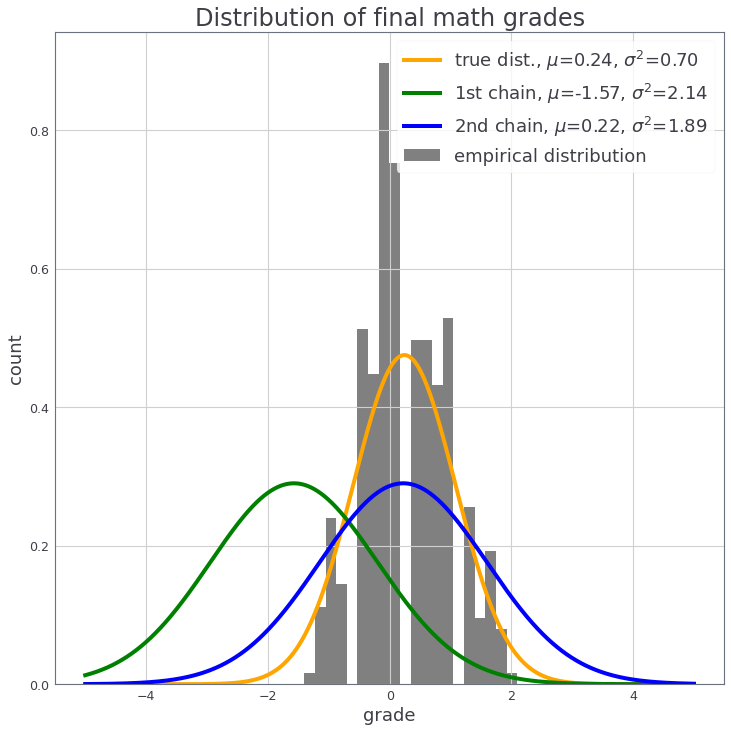

In [51]:
# instpect the grades distribution
fig = plt.figure(figsize=(12,12))

sigma_true = np.std(y_std_passed)
mu_true = np.mean(y_std_passed)
bins = np.arange(-5, 5, 0.001)

ax = fig.add_subplot(111)
ax.hist(y_std_passed, bins=20, color="grey", density=True, label="empirical distribution")

# ----------------------------------------------------------------------------------------------
# comp. of posteriors
ax.plot(bins, eval_normal_with_bins(bins, mu=mu_true, sigma=sigma_true),
    linewidth=4, color='orange', label=f"true dist., $\mu$={mu_true:.2f}, "\
        f"$\sigma^2$={sigma_true:.2f}")

ax.plot(bins, eval_normal_with_bins(bins, mu=mu_est_first_chain, sigma=sigma_est[1]),
    linewidth=4, color='green', label=f"1st chain, $\mu$={mu_est_first_chain:.2f}, "\
        f"$\sigma^2$={sigma_est[0]:.2f}")

ax.plot(bins, eval_normal_with_bins(bins, mu=mu_est_second_chain, sigma=sigma_est[1]),
    linewidth=4, color='blue', label=f"2nd chain, $\mu$={mu_est_second_chain:.2f}, "\
        f"$\sigma^2$={sigma_est[1]:.2f}")
# ----------------------------------------------------------------------------------------------

ax.set_title("Distribution of final math grades", fontsize=24)
ax.set_xlabel("grade", fontsize=18)
ax.set_ylabel("count", fontsize=18)
ax.legend(fontsize=18)

plt.savefig("../../seminar_paper/figures/students_grade_distr_est_normal_passed.png",
    transparent=True)
plt.show();

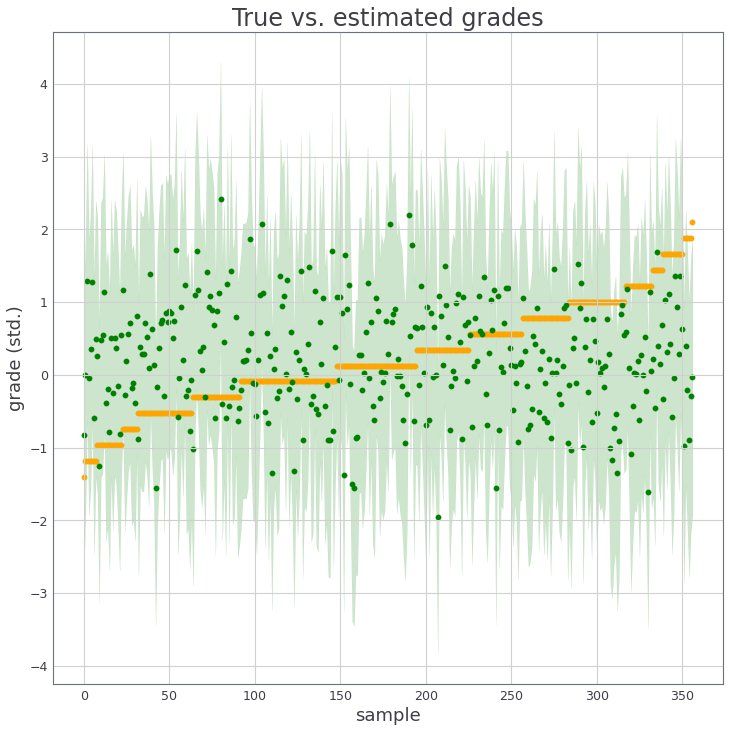

In [221]:
x = np.arange(y_std_passed.__len__())

beta_linreg = np.linalg.inv(X_converged_passed.T @ X_converged_passed) @ X_converged_passed.T @ y_std_passed
y_hat_linreg = X_converged_passed @ beta_linreg
y_hat = X_converged_passed @ beta_map[:,1]

# attach to sort 
data = np.array([y_std_passed, y_hat, y_hat_linreg]).T
data_sorted = data[data[:,0].argsort()]
std = sigma_est[1]

# plot results 
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111)
ax.fill_between(x, data_sorted[:,1] + std, data_sorted[:,1] - std, alpha=0.2, 
    color="green", label="test")
ax.scatter(x, data_sorted[:,0], color="orange", label="true grades")
ax.scatter(x, data_sorted[:,1], color="green", label="estimated grades")

ax.set_title("True vs. estimated grades", fontsize=24)
ax.set_xlabel("sample", fontsize=18)
ax.set_ylabel("grade (std.)", fontsize=18)


plt.savefig("../../seminar_paper/figures/students_grade_distr_est_interval.png",
    transparent=True)
plt.show()

## Comparison 

 - ...

### References 

- [1] _"Using Data Mining to Predict Secondary School Student Performance"_ , P. Cortez and A. Silva., 2008
- [2] _"bayestestR: Describing Effects and their Uncertainty, Existence and Significance within the Bayesian Framework"_ , Makowski, D. and Ben-Shachar, M. S. and Lüdecke, D., 2019  

### Variable names

 - school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
 - sex - student's sex (binary: 'F' - female or 'M' - male)
 - age - student's age (numeric: from 15 to 22)
 - address - student's home address type (binary: 'U' - urban or 'R' - rural)
 - famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
 - Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
 - Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
 - Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
 - Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
 - Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
 - reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
 - guardian - student's guardian (nominal: 'mother', 'father' or 'other')
 - traveltime - home to school travel time (numeric: 1 - 1 hour)
 - studytime - weekly study time (numeric: 1 - 10 hours)
 - failures - number of past class failures (numeric: n if 1<=n<3, else 4)
 - schoolsup - extra educational support (binary: yes or no)
 - famsup - family educational support (binary: yes or no)
 - paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
 - activities - extra-curricular activities (binary: yes or no)
 - nursery - attended nursery school (binary: yes or no)
 - higher - wants to take higher education (binary: yes or no)
 - internet - Internet access at home (binary: yes or no)
 - romantic - with a romantic relationship (binary: yes or no)
 - famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
 - freetime - free time after school (numeric: from 1 - very low to 5 - very high)
 - goout - going out with friends (numeric: from 1 - very low to 5 - very high)
 - Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
 - Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
 - health - current health status (numeric: from 1 - very bad to 5 - very good)
 - absences - number of school absences (numeric: from 0 to 93)
 - G1 - math grade, first period
 - G2 - math grade, second period
 - G3 - math grade, final test